In [1]:
#Name :Anjani Kumar
#Job  : IT Professional

In [2]:
# Data Description
# A backorder is the order which could not be fulfilled by the company. Due to high demand of a product, the company was not able to keep up with the delivery of the order. The backordering can lead to upsetting customer as they couldn't get what they ordered and the loyalty will decrease.
# Also, company cannot overstock every product in their inventory to avoid such situation.
# There has to be a way for the company to know for which products they can face this problem.
# So, the company has shared a data file with different input features for each product and it hopes to find a pattern inside this data which can give them some insight.
# The data file contains the historical data for some weeks prior to the week we are trying to predict. 
# The data has 23 columns including 22 features and one target column.


### Import required libraries

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)


### Load Data

In [86]:
data=pd.read_csv('Back order prediction/Training_Dataset_v2.csv')

In [88]:
data.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


# Exploratory Data Analysis

### Outlier Detection

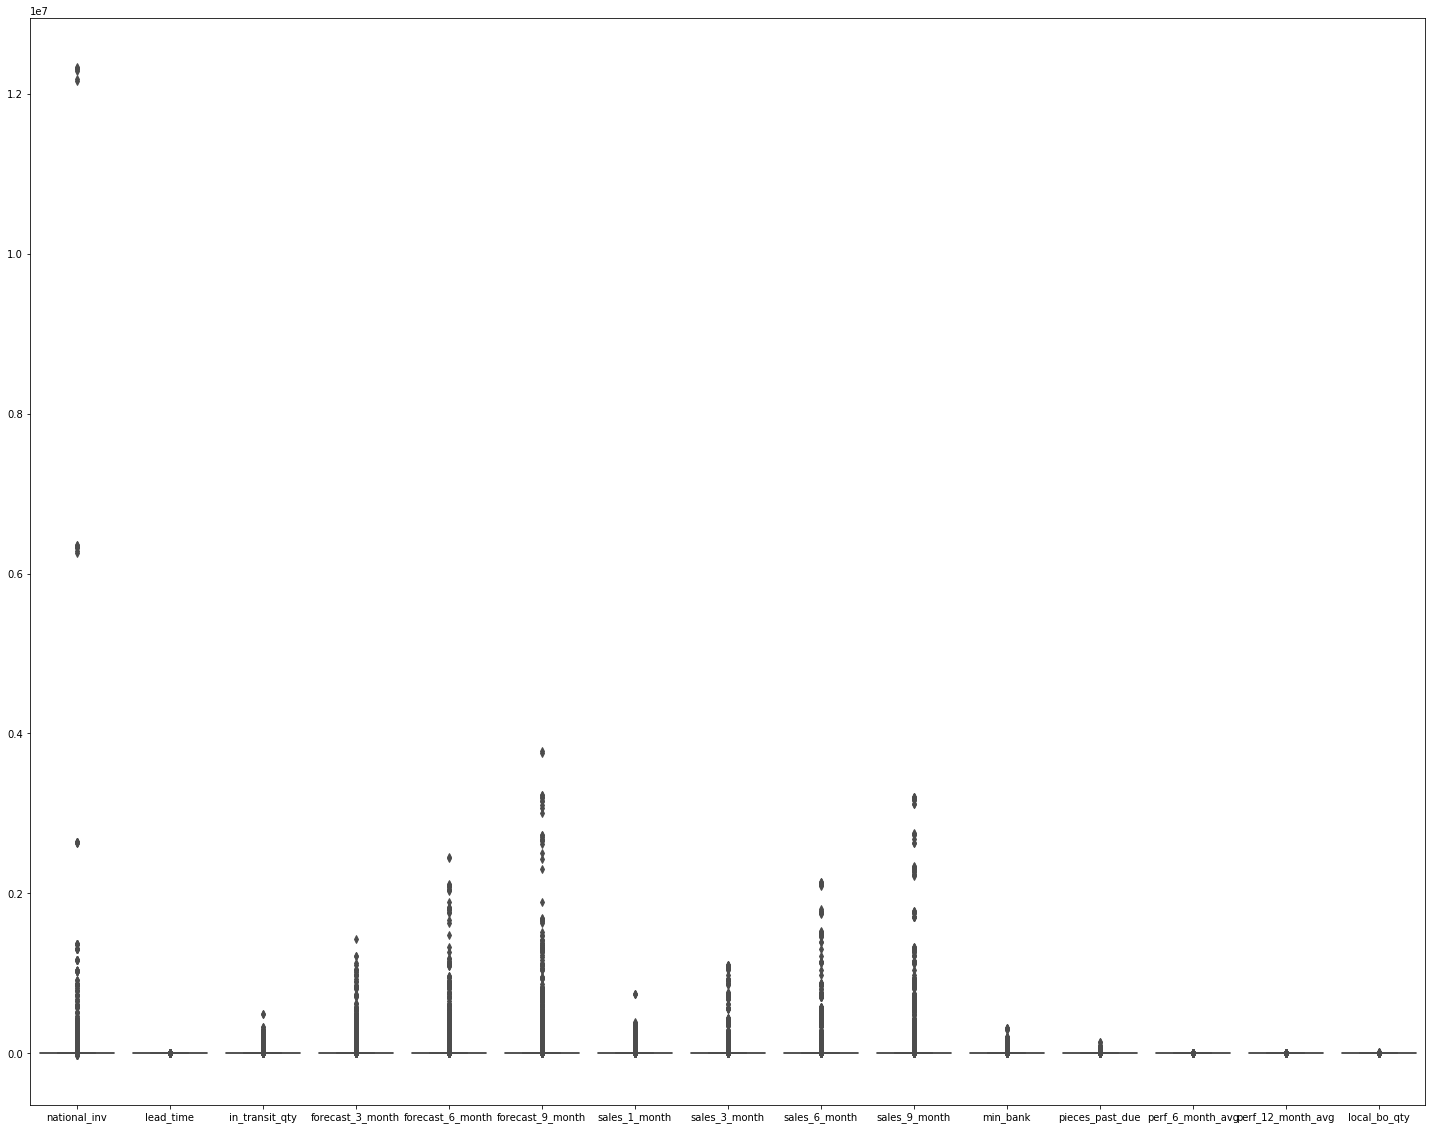

In [89]:

plt.figure(figsize=(25,20))
bplot = sns.boxplot( data=data, 
                      color='red')
bplot
plt.show()

### Outlier Removal

In [90]:
from pandas.api.types import is_numeric_dtype
def remove_outlier(df):
    low = .05
    high = .90
    quant_df = df.quantile([low, high])
    for name in list(df.columns):
        if is_numeric_dtype(df[name]):
            df = df[(df[name] > quant_df.loc[low, name]) 
               & (df[name] < quant_df.loc[high, name])]
            return df
    #remove_outlier(df).head()

In [91]:
data=remove_outlier(data)

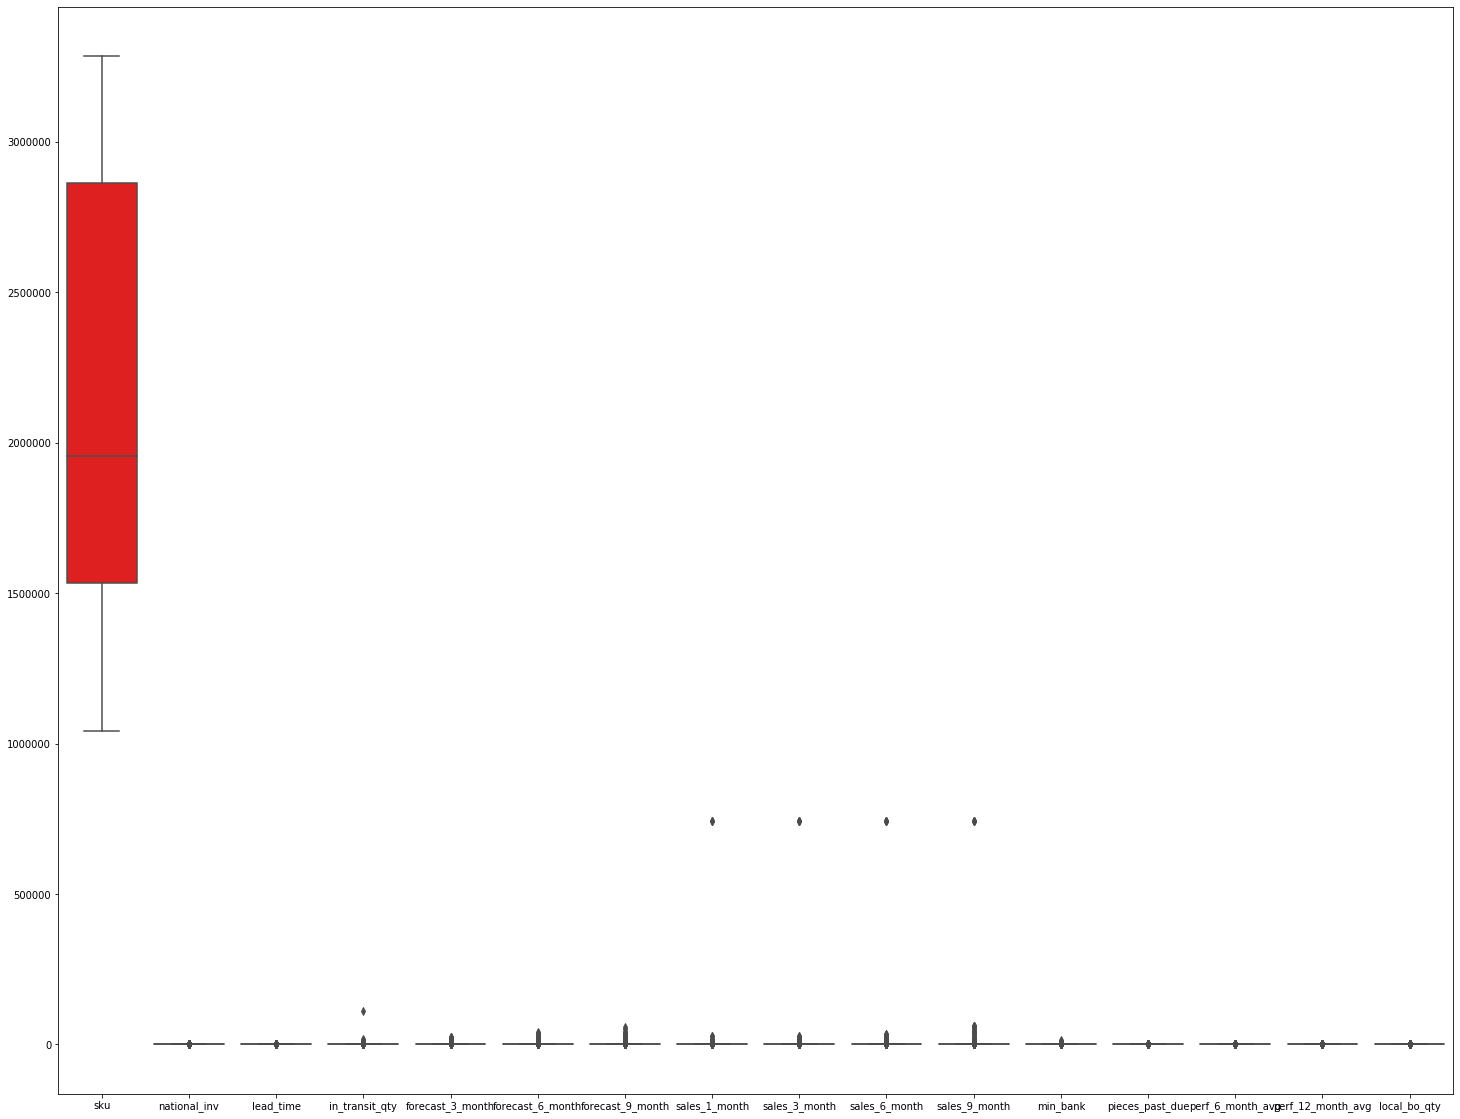

In [92]:
plt.figure(figsize=(25,20))
bplot = sns.boxplot( data=data, 
                      color='red')
bplot
plt.show()

### Seperate Independent and Dependent Variables 

In [93]:
data_X=data.loc[:,data.columns!='went_on_backorder']

In [94]:
data_y=data.loc[:,data.columns=='went_on_backorder']

In [95]:
data_X.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No
5,1044198,13.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,No,0.0,0.82,0.87,0.0,No,No,No,Yes,No


In [96]:
data_y.head()

,went_on_backorder
1,No
2,No
3,No
4,No
5,No


In [97]:
data_X.describe().astype('int64') 

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,1404672,1329273,1404672,1404672,1404672,1404672,1404672,1404672,1404672,1404672,1404672,1404672,1404672,1404672,1404672
mean,45,7,6,24,46,67,9,29,54,81,9,0,-5,-5,0
std,69,6,105,143,227,316,1085,1406,1419,1444,46,11,24,24,3
min,1,0,0,0,0,0,0,0,0,0,0,0,-99,-99,0
25%,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0
50%,13,8,0,0,0,0,0,1,2,3,0,0,0,0,0
75%,52,9,0,2,8,15,3,10,21,32,2,0,0,0,0
max,358,52,110092,26250,41682,57114,741774,742121,742763,743215,16212,3056,1,1,1435


In [98]:
#Shape of Independent features
data_X.shape

(1404672, 22)

In [99]:
#Shape of Dependent features
data_y.shape

(1404672, 1)

### EDA -  Null Value Check

In [100]:
data_X.isnull().sum().sort_values(ascending = False)

lead_time            75399
rev_stop                 0
stop_auto_buy            0
national_inv             0
in_transit_qty           0
forecast_3_month         0
forecast_6_month         0
forecast_9_month         0
sales_1_month            0
sales_3_month            0
sales_6_month            0
sales_9_month            0
min_bank                 0
potential_issue          0
pieces_past_due          0
perf_6_month_avg         0
perf_12_month_avg        0
local_bo_qty             0
deck_risk                0
oe_constraint            0
ppap_risk                0
sku                      0
dtype: int64

### Columns with value as Zero

In [101]:
data_zero=data_X.isin([0]).sum()

In [102]:
zero_data_percent=(data_zero/len(data_X))*100

In [103]:
pd.concat([data_zero,round(zero_data_percent,2)],axis=1,keys=['No_of_Zero_Records', 'Percentage'])

,No_of_Zero_Records,Percentage
sku,0,0.00
national_inv,0,0.00
lead_time,9171,0.65
in_transit_qty,1155911,82.29
forecast_3_month,1025532,73.01
forecast_6_month,941164,67.00
forecast_9_month,894668,63.69
sales_1_month,822789,58.58
sales_3_month,641409,45.66
sales_6_month,537382,38.26


### Drop below features as its having maximum value 0

In [21]:
#data_X.drop(['sku','in_transit_qty','pieces_past_due','local_bo_qty'],axis=1,inplace=True)

In [22]:
#data_X.columns

### Filling the NaN Values in Contineous Variables

In [105]:
for col in data_X.columns:
    if data_X[col].dtypes!='object':
        data_X[col].fillna(np.mean(data_X[col]),inplace=True)

In [106]:
data_X.isnull().sum().sort_values(ascending = False)

rev_stop             0
stop_auto_buy        0
national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
sku                  0
dtype: int64

In [107]:
data_X_cat=data_X.loc[:,data_X.dtypes=='object']
data_X_cat.head()

,sku,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
1,1043384,No,No,No,No,Yes,No
2,1043696,No,Yes,No,No,Yes,No
3,1043852,No,No,No,No,Yes,No
4,1044048,No,Yes,No,No,Yes,No
5,1044198,No,No,No,No,Yes,No


### NaN value updation for Categorical features by mod

In [108]:
data_X_cat.groupby(by='potential_issue').count()

,sku,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
potential_issue,,,,,,
No,1404231,1404231,1404231,1404231,1404231,1404231
Yes,441,441,441,441,441,441


In [110]:
data_X['potential_issue'].fillna('No',inplace=True)
data_X['potential_issue'].isnull().sum()

0

In [111]:
data_X_cat.groupby(by='deck_risk').count()

,sku,potential_issue,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
deck_risk,,,,,,
No,1082752,1082752,1082752,1082752,1082752,1082752
Yes,321920,321920,321920,321920,321920,321920


In [113]:
data_X['deck_risk'].fillna('No',inplace=True)
data_X['deck_risk'].isnull().sum()

0

In [114]:
data_X_cat.groupby(by='oe_constraint').count()

,sku,potential_issue,deck_risk,ppap_risk,stop_auto_buy,rev_stop
oe_constraint,,,,,,
No,1404584,1404584,1404584,1404584,1404584,1404584
Yes,88,88,88,88,88,88


In [116]:
data_X['oe_constraint'].fillna('No',inplace=True)
data_X['oe_constraint'].isnull().sum()

0

In [117]:
data_X_cat.groupby(by='ppap_risk').count()

,sku,potential_issue,deck_risk,oe_constraint,stop_auto_buy,rev_stop
ppap_risk,,,,,,
No,1245322,1245322,1245322,1245322,1245322,1245322
Yes,159350,159350,159350,159350,159350,159350


In [119]:
data_X['ppap_risk'].fillna('No',inplace=True)
data_X['ppap_risk'].isnull().sum()

0

In [34]:
data_X_cat.groupby(by='stop_auto_buy').count()

,sku,potential_issue,deck_risk,oe_constraint,ppap_risk,rev_stop
stop_auto_buy,,,,,,
No,43643,43643,43643,43643,43643,43643
Yes,1361029,1361029,1361029,1361029,1361029,1361029


In [120]:
data_X['stop_auto_buy'].fillna('Yes',inplace=True)
data_X['stop_auto_buy'].isnull().sum()

0

In [121]:
data_X_cat.groupby(by='rev_stop').count()

,sku,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy
rev_stop,,,,,,
No,1404481,1404481,1404481,1404481,1404481,1404481
Yes,191,191,191,191,191,191


In [123]:
data_X['rev_stop'].fillna('No',inplace=True)
data_X['rev_stop'].isnull().sum()

0

In [124]:
data_y['went_on_backorder'].isnull().sum()
data_y['went_on_backorder'].fillna('No',inplace=True)
data_y['went_on_backorder'].isnull().sum()

0

### Final Data after NaN values removal

In [125]:
data_X.isnull().sum().sort_values(ascending = False)

rev_stop             0
stop_auto_buy        0
national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
sku                  0
dtype: int64

### Create Correlation DataFrame

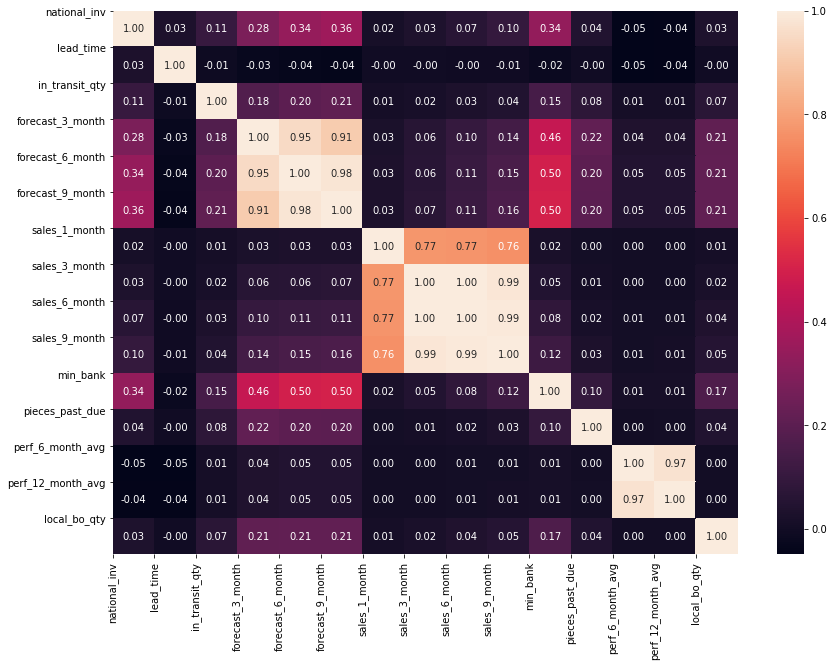

In [126]:
corr=data_X.corr()
#Plot figsize
fig,ax=plt.subplots(figsize=(14,10))

 #Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr,annot=True,fmt=".2f")    

#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
plt.show()

### Identify Highly Correlated 

In [127]:
# Create correlation matrix
corr_matrix = data_X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(to_drop)

['forecast_6_month', 'forecast_9_month', 'sales_6_month', 'sales_9_month', 'perf_12_month_avg']


### Scatter Plot

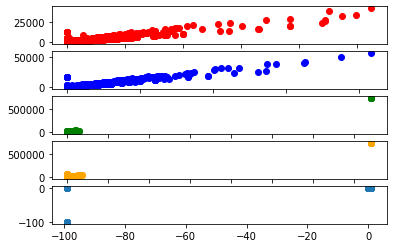

In [128]:
plt.subplot(5,1,1)
plt.scatter(x=data_X['forecast_3_month'],y=data_X['forecast_6_month'],c='red')
plt.subplot(5,1,2)
plt.scatter(x=data_X['forecast_6_month'],y=data_X['forecast_9_month'],c='blue')
plt.subplot(5,1,3)
plt.scatter(x=data_X['sales_3_month'],y=data_X['sales_6_month'],c='green')
plt.subplot(5,1,4)
plt.scatter(x=data_X['sales_6_month'],y=data_X['sales_9_month'],c='orange')
plt.subplot(5,1,5)
plt.scatter(x=data_X['perf_6_month_avg'],y=data_X['perf_12_month_avg'])
plt.show()



In [129]:
data_X.drop(['sku'],axis=1,inplace=True)

C:\Users\akumar4\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [130]:
data_X.shape

(1404672, 21)

<Figure size 1800x1440 with 0 Axes>

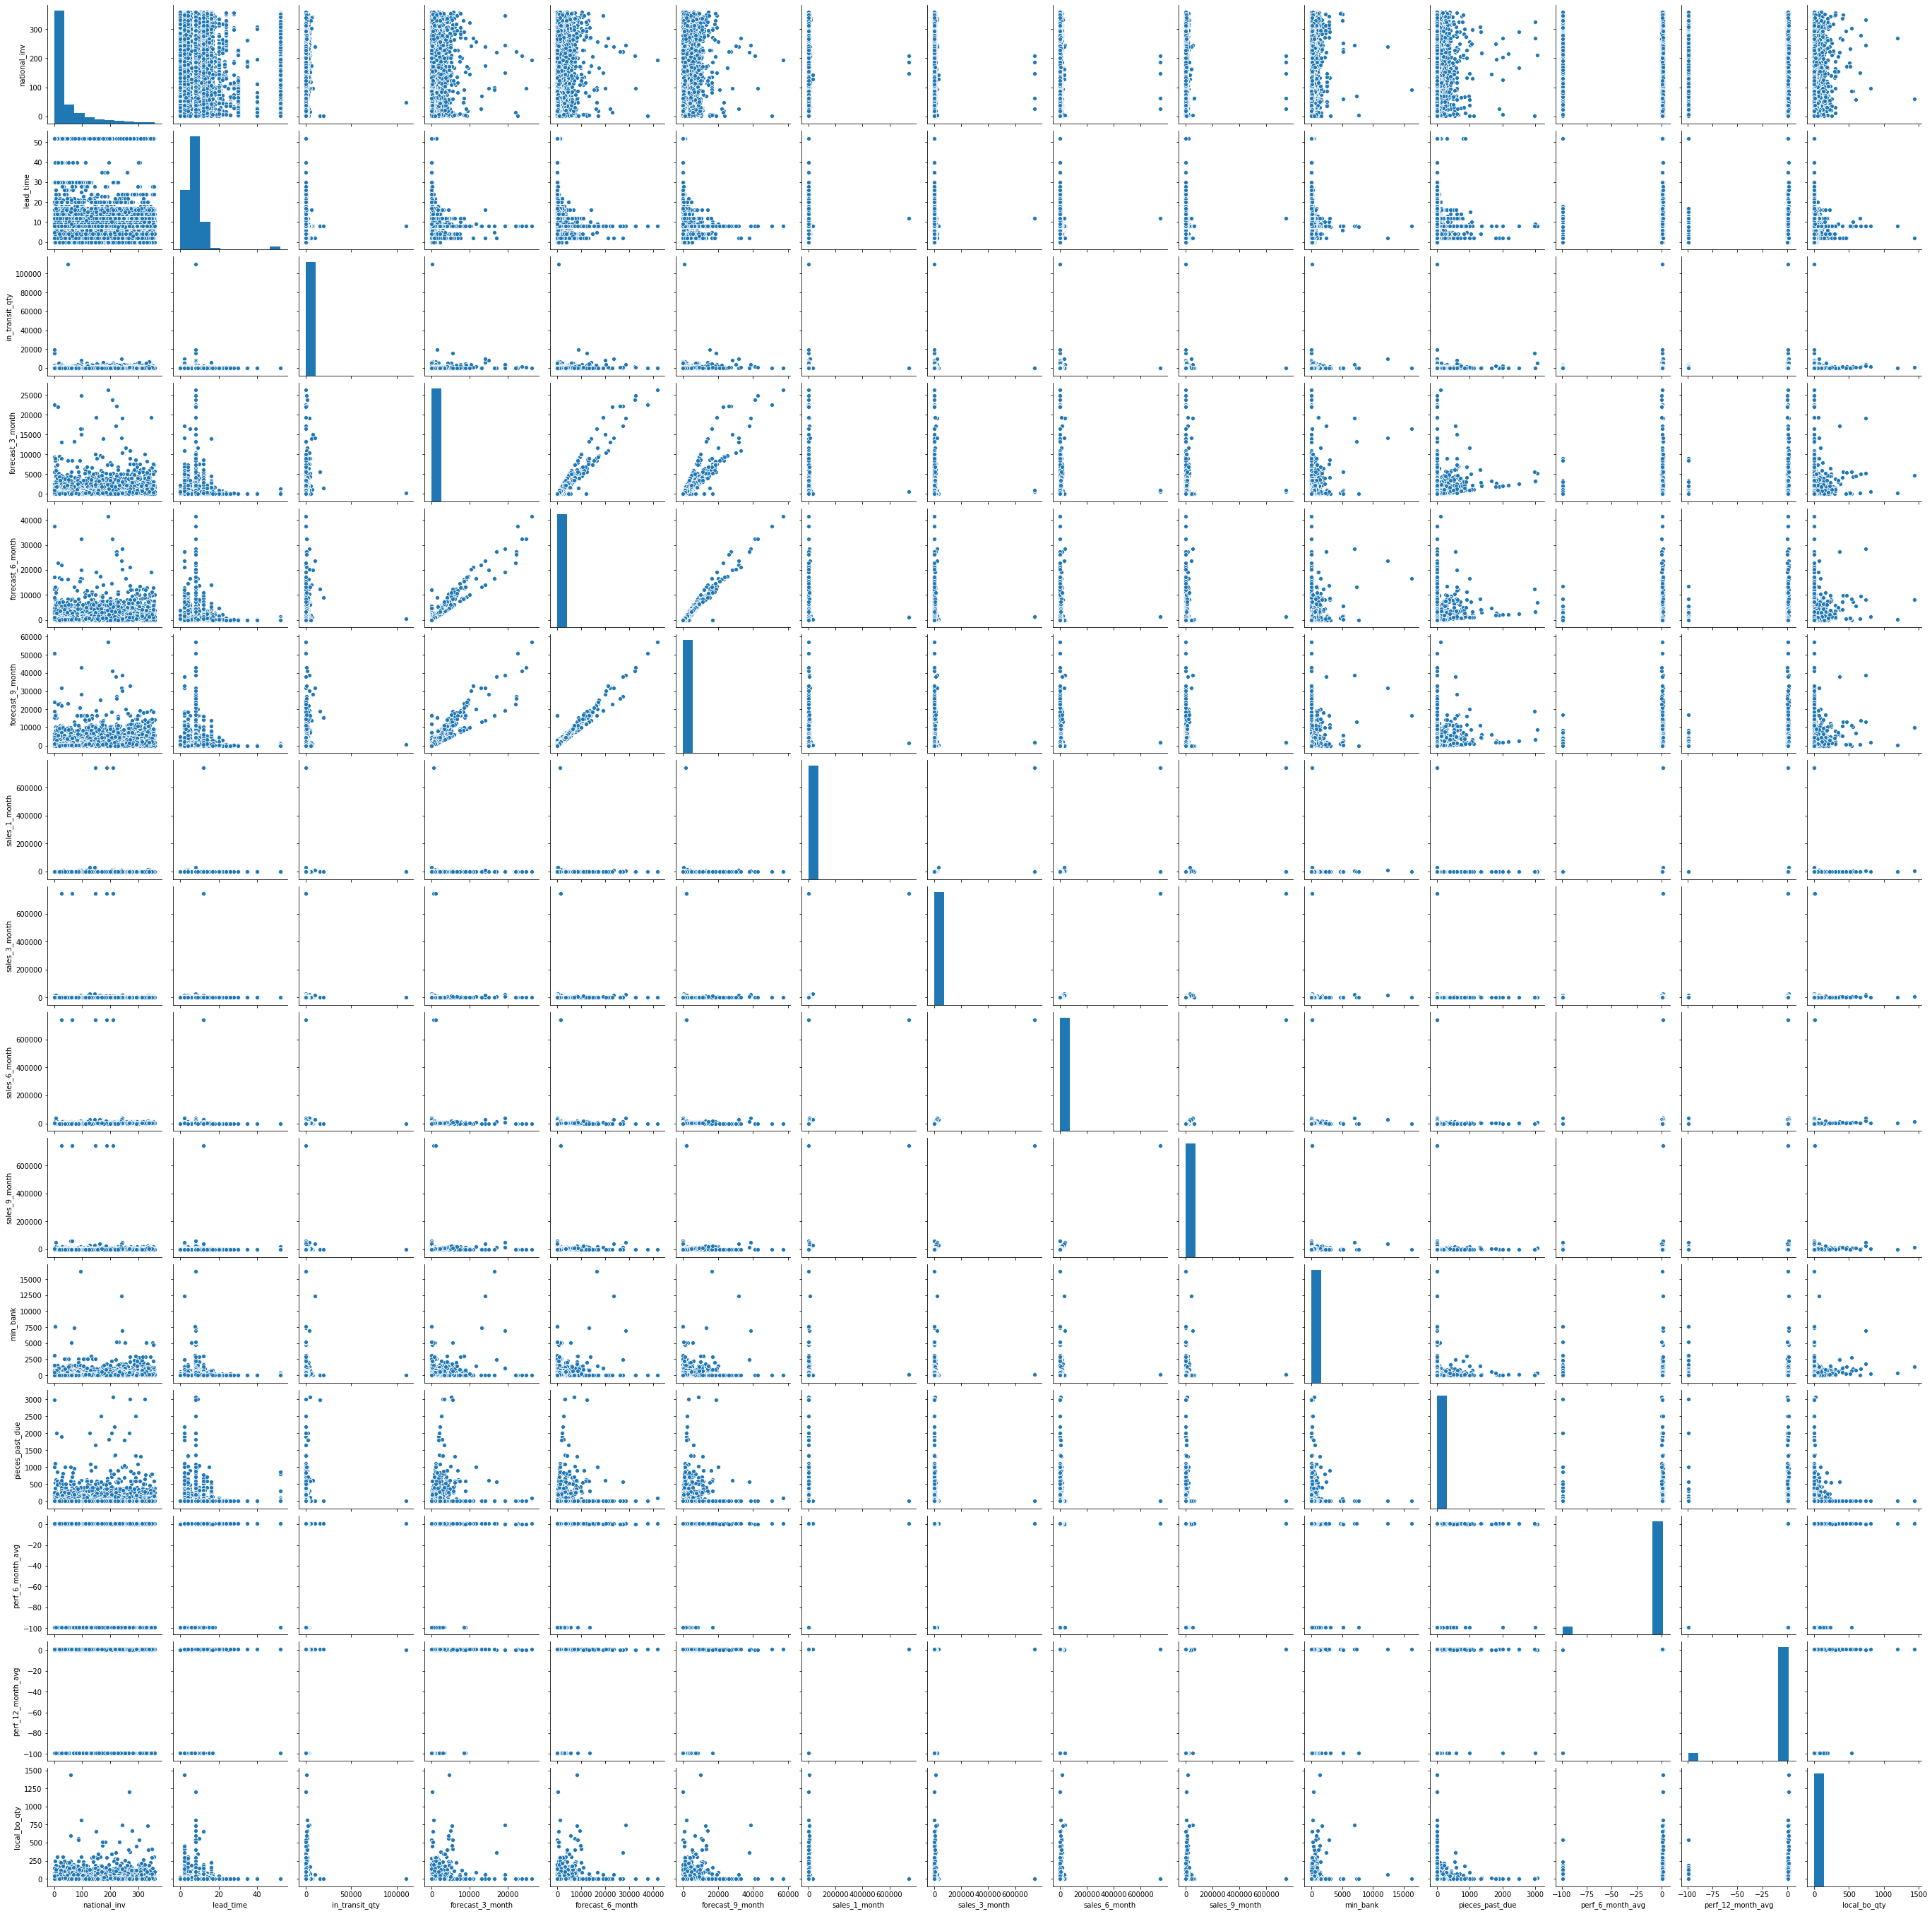

In [45]:
plt.figure(figsize=(25,20))
sns.pairplot(data_X)
plt.show()

### Label Encoding Categorical Variables

In [131]:
le=LabelEncoder()

In [133]:
#Target Variable
y_enc=le.fit_transform(data_y)

In [134]:
y_enc=pd.DataFrame(y_enc,columns=['went_on_backorder'])

In [135]:
#Random ID for the product and not usefull
#data_X=data_X.drop(['sku'],axis=1)

In [136]:
#Independent Variables
X_enc=data_X.loc[:,data_X.dtypes=='object'].apply(lambda coldata :le.fit_transform(coldata))

In [137]:
X_enc.head()

,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
1,0,0,0,0,1,0
2,0,1,0,0,1,0
3,0,0,0,0,1,0
4,0,1,0,0,1,0
5,0,0,0,0,1,0


In [138]:
data_X_cont=data_X.loc[:,data_X.dtypes!='object']
data_X_cont.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
1,2.0,9.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99,0.99,0.0
2,2.0,7.81603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-99.00,-99.00,0.0
3,7.0,8.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.10,0.13,0.0
4,8.0,7.81603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,-99.00,-99.00,0.0
5,13.0,8.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.82,0.87,0.0


### Merging Contineous Variables and Encoded Categorical Variables

In [139]:
X_enc=pd.concat([data_X_cont,X_enc],axis=1)

In [140]:
X_enc.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
1,2.0,9.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,0,0,0,0,1,0
2,2.0,7.81603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,0,1,0,0,1,0
3,7.0,8.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,0,0,0,0,1,0
4,8.0,7.81603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,-99.00,-99.00,0.0,0,1,0,0,1,0
5,13.0,8.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.82,0.87,0.0,0,0,0,0,1,0


# Feature Engineering/Feature Selection

### Drop Highly Correlated Features

In [141]:
X_enc=X_enc.drop(['forecast_6_month','forecast_9_month', 'sales_6_month', 'sales_9_month','perf_12_month_avg'],axis=1)

In [142]:
X_enc.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,sales_1_month,sales_3_month,min_bank,pieces_past_due,perf_6_month_avg,local_bo_qty,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
1,2.0,9.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.99,0.0,0,0,0,0,1,0
2,2.0,7.81603,0.0,0.0,0.0,0.0,0.0,0.0,-99.00,0.0,0,1,0,0,1,0
3,7.0,8.00000,0.0,0.0,0.0,0.0,1.0,0.0,0.10,0.0,0,0,0,0,1,0
4,8.0,7.81603,0.0,0.0,0.0,0.0,2.0,0.0,-99.00,0.0,0,1,0,0,1,0
5,13.0,8.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.82,0.0,0,0,0,0,1,0


In [143]:
X_enc.shape

(1404672, 16)

### Rechecking if there exists any correlation between features

In [144]:
# Create correlation matrix
corr_matrix = X_enc.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(to_drop)

[]


### Data Imbalance Check

In [145]:
Yes_Data=data['went_on_backorder'][data['went_on_backorder']=='Yes'].count()
No_Data=data['went_on_backorder'][data['went_on_backorder']=='No'].count()

In [146]:
Yes_Data

6397

In [147]:
No_Data

1398275

In [148]:
#over_samp=SMOTETomek(random_state=24)
#X_res,Y_res=over_samp.fit_sample(X_enc,y_enc)

In [149]:
y_enc.head()

,went_on_backorder
0,0
1,0
2,0
3,0
4,0


### Using Under Sampling Technique to fix data imbalance problem

In [150]:
under_sampl=NearMiss()
X_res,Y_res=under_sampl.fit_sample(X_enc,y_enc)

In [151]:
X_res.shape

(12794, 16)

In [152]:
Y_res.shape

(12794, 1)

### Train_Test_Split

In [153]:
X_train,X_test,y_train,y_test=train_test_split(X_res, Y_res,test_size=0.20,random_state=20)

### Hyper Parameter Tuning

In [154]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in range(1,501)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in range(1,501)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
# {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 

### Model Selection Random Forest

In [155]:
from sklearn.ensemble import RandomForestClassifier


In [156]:
rfc=RandomForestClassifier(n_estimators=100,max_depth=50,min_samples_leaf=100,min_samples_split=200)

In [157]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.3min finished
C:\Users\akumar4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=50,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=100,
                                                    min_samples_split=200,
                                                    min_weight_fraction_leaf=0.0,
             

In [158]:
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 40,
 'min_samples_leaf': 32,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}

In [159]:
rfc=RandomForestClassifier(n_estimators=1200,max_depth=60,min_samples_leaf=32,min_samples_split=40,max_features='sqrt',bootstrap=False)

In [160]:
rfc.fit(X_train,y_train)

C:\Users\akumar4\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=40,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [161]:
rfc.score(X_test,y_test)

0.9695193434935522

In [162]:
y_pred=rfc.predict(X_test)

In [163]:
#cross_val_score(rfc,X_train,y_train, cv=10)

In [164]:
#y_pred=cross_val_predict(rfc, X_train,y_train, cv=10)

In [165]:
from sklearn.model_selection import cross_val_score
cvs=cross_val_score(rfc,X_res,Y_res,cv=100)

C:\Users\akumar4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\akumar4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\akumar4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\akumar4\AppData\Local\Continuum\anaconda3\l

In [166]:
cvs.mean()

0.9693645423228346

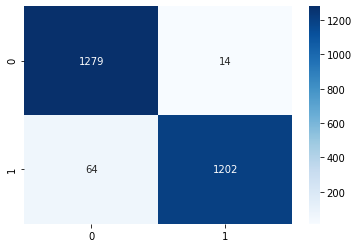

In [167]:
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='.4g',cmap='Blues')
plt.show()

In [168]:
ac=accuracy_score(y_test,y_pred)
ac

0.9695193434935522

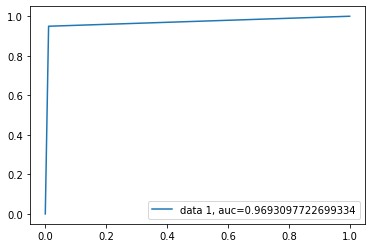

In [169]:
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Model Selection Logistic Regression

In [170]:
from sklearn.linear_model import LogisticRegression

In [171]:
lr=LogisticRegression()

In [172]:
lr.fit(X_train,y_train)

C:\Users\akumar4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\akumar4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [173]:
y_pred_lr=lr.predict(X_test)

In [174]:
cm=confusion_matrix(y_test,y_pred_lr)

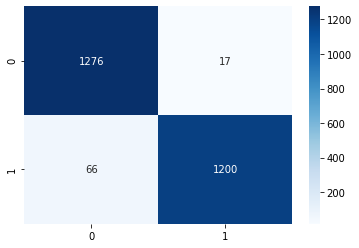

In [175]:
sns.heatmap(cm,annot=True,fmt='.4g',cmap='Blues')
plt.show()

In [176]:
acl=accuracy_score(y_test,y_pred_lr)

In [177]:
acl

0.9675654552559594

In [178]:
from sklearn.model_selection import cross_val_score
cvs=cross_val_score(lr,X_res,Y_res,cv=100)

C:\Users\akumar4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\akumar4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\akumar4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passe

In [179]:
cvs.mean()

0.9628001968503938

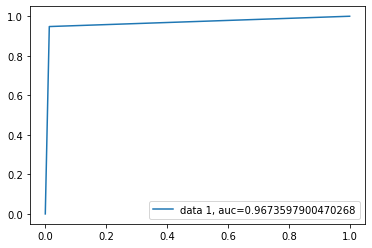

In [180]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_lr)
auc = roc_auc_score(y_test, y_pred_lr)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Model Selection SVC

In [181]:
from sklearn.svm import SVC

In [182]:
svm=SVC()

In [183]:
svm.fit(X_train,y_train)

C:\Users\akumar4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [184]:
y_pred_svm=svm.predict(X_test)

In [185]:
cm=confusion_matrix(y_test,y_pred_svm)
cm

array([[1292,    1],
       [ 299,  967]], dtype=int64)

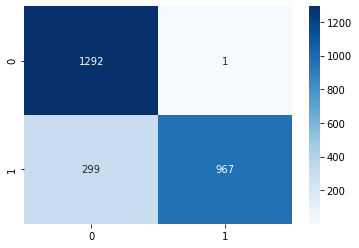

In [186]:
sns.heatmap(cm,annot=True,fmt='.4g',cmap='Blues')
plt.show()

In [187]:
acsvm=accuracy_score(y_test,y_pred_svm)


In [188]:
acsvm

0.8827667057444314

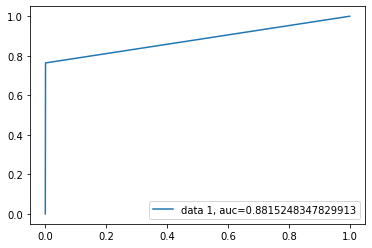

In [190]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_svm)
auc = roc_auc_score(y_test, y_pred_svm)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()